In [24]:
import json
import os
import pickle

import torch
import torchvision
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

from models import ARCNN, ResNetD, ResNetD3


set_matplotlib_formats("retina")
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"

In [18]:
QUALITY = 40
ORIGINAL_IMAGE = "data/100/test/16068.jpg"
TEST_IMAGE = f"data/{QUALITY}/test/16068.jpg"
MODEL_PATH = f"models/ResNetD-quality{QUALITY}-v0.1/ResNetD.pt"
# MODEL_PATH = "models/ARCNNv0.4/ARCNN.pt"

In [19]:
net = ResNetD()
net.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
net

/var/folders/89/b5lh60hs3x1g1db4v2dx04980000gn/T/ipykernel_49504/1377331834.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(MODEL_PATH, ma

ResNetD(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv4): Conv2d(16, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (relu1): LeakyReLU(negative_slope=0.25)
  (relu2): LeakyReLU(negative_slope=0.25)
  (relu3): LeakyReLU(negative_slope=0.25)
)

In [20]:
def enhance(image):
    tofloat = torchvision.transforms.ConvertImageDtype(torch.float32)
    x = tofloat(image)
    with torch.no_grad():
        y = net(x)
    y = torch.clip(y, 0.0, 1.0)
    res = y.cpu()
    return res

In [21]:
tofloat = torchvision.transforms.ConvertImageDtype(torch.float32)

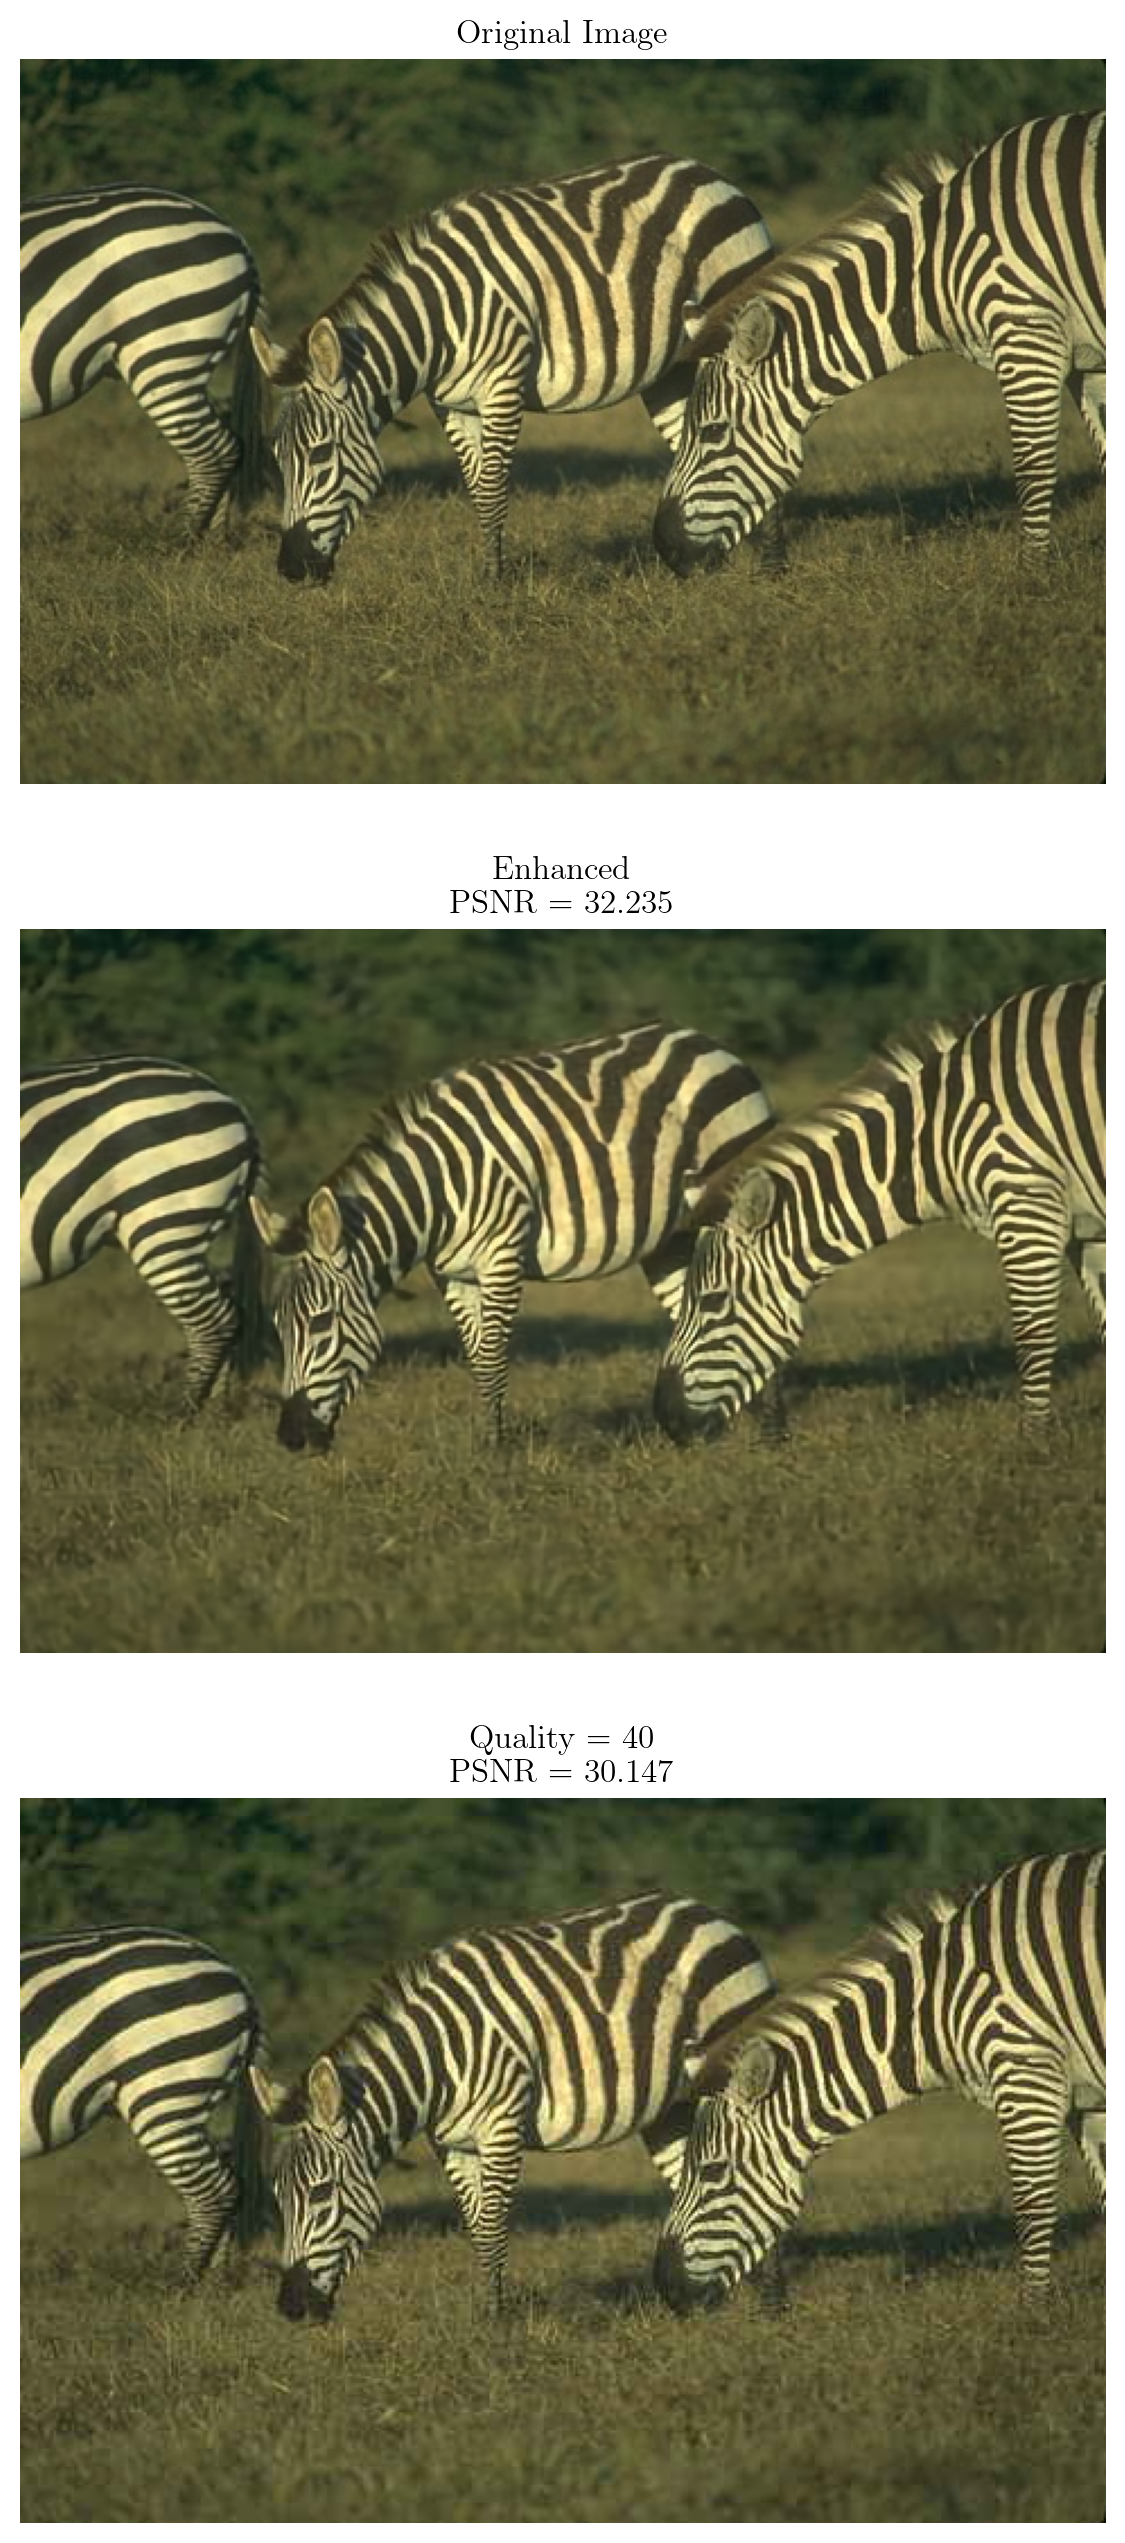

In [23]:
original = torchvision.io.read_image(ORIGINAL_IMAGE)
image = torchvision.io.read_image(TEST_IMAGE)
enhanced = enhance(image)

enhanced_mse = torch.mean((tofloat(original) - tofloat(enhanced)) ** 2).item()
enhanced_psnr = 10 * np.log10(1 / enhanced_mse)

baseline_mse = torch.mean((tofloat(image) - tofloat(original)) ** 2).item()
baseline_psnr = 10 * np.log10(1 / baseline_mse)

c, h, w = image.shape

fig, axs = plt.subplots(3, 1, figsize=(9, 16))
axs[0].imshow(original.permute(1,2,0).numpy())
axs[1].imshow(enhanced.permute(1,2,0).numpy())
axs[2].imshow(image.permute(1,2,0).numpy())

axs[0].set_title("Original Image")
axs[1].set_title(f"Enhanced\nPSNR = {enhanced_psnr:.3f}")
axs[2].set_title(f"Quality = {QUALITY}\nPSNR = {baseline_psnr:.3f}")

for ax in axs:
    ax.set_axis_off()


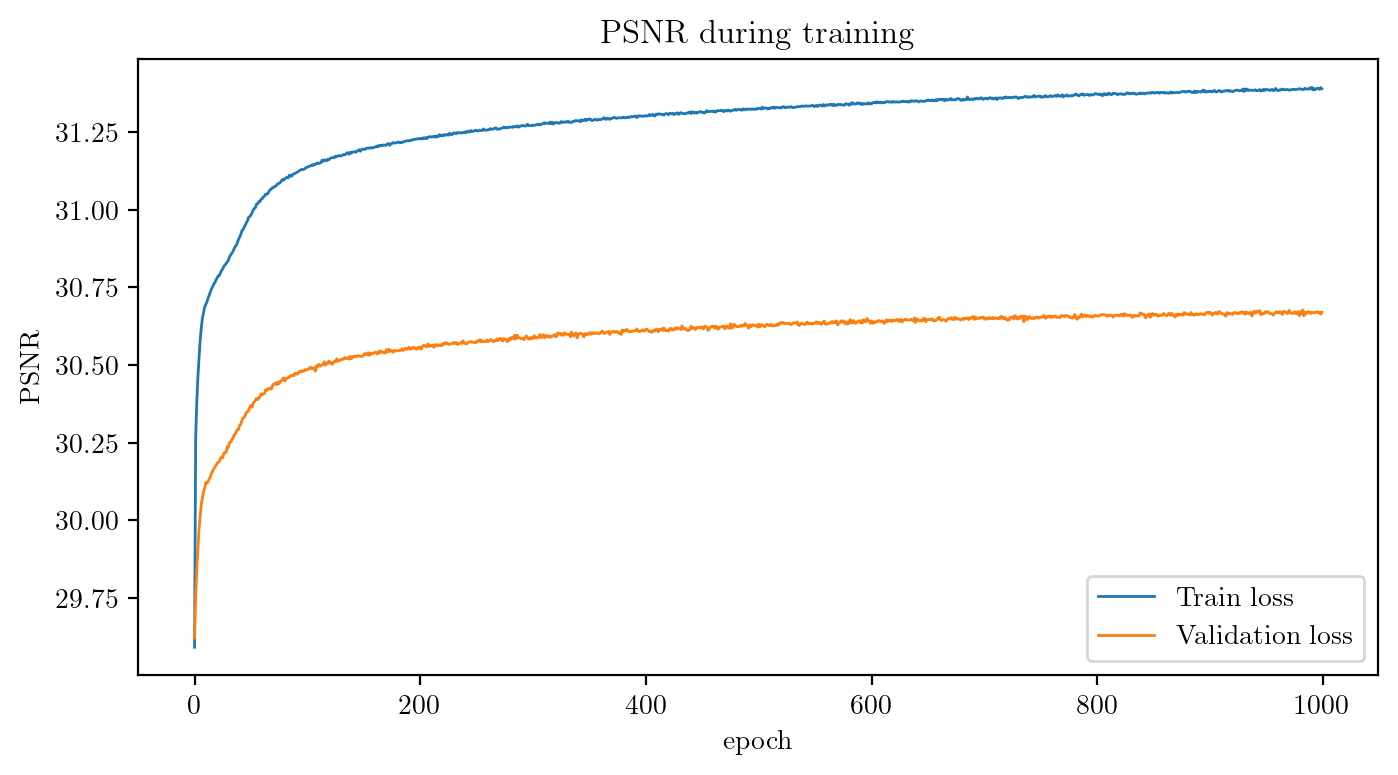

In [40]:
fig, ax = plt.subplots(figsize=(8,4))

with open(f"models/ResNetD-quality{QUALITY}-v0.1/train-stats.json", mode="r") as f:
    data = json.load(f)
    ax.plot(data["epoch"], data["psnr"], color="tab:blue", linewidth=1, label="Train loss")

with open(f"models/ResNetD-quality{QUALITY}-v0.1/val-stats.json", mode="r") as f:
    data = json.load(f)
    ax.plot(data["epoch"], data["psnr"], color="tab:orange", linewidth=1, label="Validation loss")

ax.set_xlabel("epoch")
ax.set_ylabel("PSNR")
ax.set_title("PSNR during training")
ax.legend(loc="lower right")
